In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mtcnn.caffe_pb2 as pb
import cv2 as cv

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# caffe 的权重模型为(ic, oc, kh, kw)
# 解析模型
# net = pb.NetParameter()
# with open('mtcnn/det1.caffemodel', 'rb') as f:
#     net.ParseFromString(f.read())
# # list(net.layer[8].blobs[0].data)
# net.layer[7].blobs[0].shape

In [2]:
class BBox:
    def __init__(self, l, t, r, b, confidence=0):
        self.l = l
        self.t = t
        self.r = r
        self.b = b
        self.confidence = confidence

    def iouOf(self, other):
        # IOU：交并比
        a = self
        b = other
        c_width  = min(a.r, b.r) - max(a.l, b.l)  # 小右减大左
        c_height = min(a.b, b.b) - max(a.t, b.t)  # 小底减大顶
        if(c_width <= 0 or c_height <= 0):
            return 0
        area_i = c_width * c_height       # 交集
        area_u = a.area + b.area - area_i # 并集
        return area_i / area_u
       
    def locations(self):
        return self.l, self.t, self.r, self.b

    @property
    def left_top(self):
        return int(self.l + 0.5), int(self.t + 0.5)

    @property
    def right_bottom(self):
        return int(self.r + 0.5), int(self.b + 0.5)

    @property
    def center_x(self):
        return (self.l + self.r) * 0.5

    @property
    def center_y(self):
        return (self.t + self.b) * 0.5

    @property
    def area(self):
        return self.width * self.height

    @property
    def width(self):
        # 1到2，算两个像素(2-1+1)
        return self.r - self.l + 1

    @property
    def height(self):
        return self.b - self.t + 1

    def __repr__(self):
        return f'BBox {{ {self.l}, {self.t}, {self.r}, {self.b}, conf:{self.confidence}}}'


def nms(objs, iou_threshold):
    objs = sorted(objs, key=lambda x: x.confidence, reverse=True)
    removed_flags = [False] * len(objs)

    keeps = []

    # 两两对比，iou过高的就打上remove标
    for i in range(len(objs)):
        if removed_flags[i]:
            continue
        a = objs[i]
        keeps.append(a)
        for j in range(i+1, len(objs)):
            if removed_flags[j]:
                continue
            b = objs[j]
            if a.iouOf(b) > iou_threshold:
                removed_flags[j] = True
    return keeps

# a = BBox(0, 0, 100, 100, 0.9)
# b = BBox(80, 80, 180 ,180, 0.95)
# # a.iouOf(b)
# nms([a, b], 0.01)

# a = BBox(0, 0, 100, 100)
# b = BBox(180, 180, 280 ,280)
# a.iouOf(b)

In [3]:
# 定义模块，所有的模块将会继承该基类
class Module:
    def __init__(self):
        self.train_mode = True
        
    def __call__(self, *args):
        return self.forward(*args)
    
    # 训练时
    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()
        
    # 评估时，测试时
    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
        
    def modules(self):
        ms = []
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms
    
    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)
            
        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps
    
    def info(self, n):
        ms = self.modules()
        name = self.__class__.__name__
        output = f"{name}\n"
        for m in ms:
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n"
        return output[:-1]
    
    def __repr__(self):
        return self.info(0)
    
    
# 定义参数类，所有需要迭代更新的参数都会继承该类
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros(data.shape)
        
    def zero_grad(self):
        self.grad[...] = 0


class Linear(Module): 
    def __init__(self, num_input, num_output):
        super().__init__()
        self.weight = Parameter(np.random.normal(0, 1 / np.sqrt(num_input), size=(num_input, num_output)))  # 初始化权重
        self.bias   = Parameter(np.zeros((num_output,)))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return x @ self.weight.data + self.bias.data
    
    def backward(self, g):  # 反向传播
        self.weight.grad += self.x.T @ g
        self.bias.grad   += np.sum(g, axis=0)
        return g @ self.weight.data.T
    
    
class Sigmoid(Module):  # 定义激活函数对象
    def __init__(self):
        super().__init__()
    
    def sigmoid_impl(self, x):  #定义激活函数 
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return self.sigmoid_impl(x)
    
    def backward(self, g):  # 反向传播
        return g * self.sigmoid_impl(self.x) * (1 - self.sigmoid_impl(self.x))
    
class Sequencial(Module):
    def __init__(self, *args):
        super().__init__()
        self.items = list(args)
        
    def modules(self):
        return self.items
    
    def forward(self, x):
        for m in self.items:
            x = m(x)
        return x
    
    def backward(self, G):
        for item in self.items[::-1]:
            G = item.backward(G)
        return G

class Conv2d(Module):
    def __init__(self, in_channel=1, out_channel=1, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.in_channel = in_channel
        self.channel = out_channel
        self.k_size  = kernel_size
        self.stride  = stride
        self.padding = padding
        kernel_shape = (out_channel, in_channel, kernel_size, kernel_size)
        fan_mode     = kernel_size * kernel_size * out_channel
        self.weight  = Parameter(np.random.normal(0, 1 / np.sqrt(fan_mode),size=kernel_shape))
        self.bias    = Parameter(np.zeros((out_channel, 1)))
        
    def gemm_im2col(self):
        if self.padding:
            self.tensor = np.pad(self.tensor, \
                pad_width=((0,0),(0,0),(self.padding,self.padding),(self.padding,self.padding)))
        ko, ki, kh, kw = self.weight.data.shape   # out_channel, inchannel, h, w 
        b, c, h, w = self.tensor.shape       # BCHW of image
        # 我的算法
        # 如果stride为1时可移动n次
        # ceil(n / stride) 是向下取整
        # n // stride + 1 为向上取整
        # 上取整用ceil，下取整用去尾
        h_move = (w - kw) // self.stride + 1
        v_move = (h - kh) // self.stride + 1
        s          = h_move * v_move    # s:单图列数， c:图片张数  s*b=总列数

        # init
        column = np.zeros((ki * kw * kh, s * b)).astype(np.float32)
        col_kernel = self.weight.data.reshape(ko, -1)  # c -> out_channel

        for ib in range(b):
            for iy in range(v_move):
                for ix in range(h_move):
                    x, y     = ix * self.stride, iy * self.stride
                    values   = self.tensor[ib, :, y:y+kh, x:x+kw].reshape(kh * kw * c)
                    col_idx  = ix + iy*h_move + ib * s # kernel每滑动一次就换一列
                    column[:, col_idx] = values
        output = col_kernel @ column
        return output, column, h_move, v_move
    
    def gemm_col2im(self, column, image_shape, img_col_ctr):
        '''
        img_col_ctr: 一张图片column化后的列数
        '''
        imb, imc, imh, imw  = image_shape   # BCHW
        if self.padding:
            imh += 2 * self.padding
            imw += 2 * self.padding
        kh = kw        = self.k_size
        # k_size         = kh * kw
        h_move         = np.math.ceil((imw - kw + 1) / self.stride)
        output         = np.zeros((imb, imc, imh, imw))
        for b in range(imb):
            for c in range(imc): # 也即in-channel
                for col in range(img_col_ctr):
                    cx     = col + b * img_col_ctr
                    values = column[:, cx].reshape(-1, kh, kw)
                    i_row  = (col // h_move) * self.stride # 5//3 = 1
                    i_col  = (col % h_move) * self.stride  # 5%3  = 2
                    output[b, :, i_row:i_row+kh, i_col:i_col+kw] = values
        if self.padding:
            return output[..., self.padding:-self.padding, self.padding:-self.padding]
        else:
            return output
        
    def forward(self, x):
        self.tensor = x
        b, _, self.h, self.w = x.shape
        conv_img, col_img, ncol, nrow = self.gemm_im2col()
        self.x   = col_img
        output = conv_img + self.bias.data
        output = np.array(np.hsplit(output, b)).reshape(b, self.channel, nrow, ncol)
        return output

    def backward(self, g):
            # d(w @ x) / dw
            b, c, h, w = g.shape
            back_g = g[0].reshape(c, h*w)
            for ib in range(1, b):
                back_g = np.append(back_g, g[ib].reshape(c, h*w), axis=1)
            w_grad           = back_g @ self.x.T 
            self.weight.grad += w_grad.reshape(self.weight.data.shape)
            # d(w @ x + b) / db
            self.bias.grad   += np.sum(g, axis=(0,2,3))[...,None]

            # d(w @ x) / dx
            weight     = self.weight.data.reshape(self.channel, -1)
            column     = weight.T @ back_g # g.reshape(self.channel, -1)

            imgshape   = (b, self.in_channel, self.h, self.w) # 原图大小
            return self.gemm_col2im(column, imgshape, h*w)

class MaxPooling2d(Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        
    def forward(self, M):
        (b, c, h, w), k, s = M.shape, self.kernel_size, self.stride
        y_move = np.math.ceil((h - k) / s) + 1
        x_move = np.math.ceil((w - k) / s) + 1
        output = np.empty((b, c, y_move, x_move))
        for y in range(y_move):
            for x in range(x_move):
                output[:,:,y,x] = np.max(M[:, :, y*s:y*s+k, x*s:x*s+k], axis=(2, 3))
#         print('DEBUG raw:\n', M[0,0,0:2,2:4])
#         print('DEBUG max:', output[0,0,0,1])
        return output
    
class ReLU(Module):
    def __init__(self, inplace=True):
        super().__init__()
        self.inplace = inplace

    def forward(self, x):
        self.negative_position = x < 0
        if not self.inplace:
            x = x.copy()
            
        x[self.negative_position] = 0
        return x
    
    def backward(self, G):
        if not self.inplace:
            G = G.copy()
            
        G[self.negative_position] = 0
        return G
    
class PReLU(Module):
    def __init__(self, num_feature, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.coeff = Parameter(np.zeros((num_feature)))
        
    def forward(self, x):
        if not self.inplace:
            x = x.copy()
            
        for channel in range(x.shape[1]):
            view = x[:, channel]
            negative_position = view < 0
            view[negative_position] *= self.coeff.data[channel]
        return x
    
class Softmax(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        expx = np.exp(x)
        sumx = np.sum(expx, axis=1, keepdims=True)
        return expx / sumx
    
class Flatten(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.in_shape = x.shape
        out = x.reshape(self.in_shape[0], -1)
        return out
    
    def backward(self, G):
        return G.reshape(self.in_shape)

In [4]:
class CaffeModelLoader:
    def load_weight(self, weight_file, *name_layer_pairs):
        '''
        @weight_file: weight_file
        @name_layer_pairs: [(name, layer), (name, layer)]
        '''
        net = pb.NetParameter()
        with open(weight_file, 'rb') as f:
            net.ParseFromString(f.read())
        state_dict = {item.name: item for item in net.layer}
        for name, layer in name_layer_pairs:
#             param_data = state_dict[name]  # 在instance判断前使用可能会有key_error
            if isinstance(layer, Conv2d):
                self.load_conv2d_param(layer, state_dict[name])
            elif isinstance(layer, PReLU):
                self.load_prelu_param(layer, state_dict[name])
            elif isinstance(layer, Linear):
                self.load_linear_param(layer, state_dict[name])
                
    def load_conv2d_param(self, layer_instance, param_data):
        conv_weight = layer_instance.weight.data
        conv_bias   = layer_instance.bias.data
#         print('加载卷积参数:\t', param_data.name)
        # 这里用[:]是为了将改动传回layer_instance，如果直接赋值，引用地址就变了
        conv_weight[:] = np.array(param_data.blobs[0].data, np.float32).reshape(conv_weight.shape)
        conv_bias[:]   = np.array(param_data.blobs[1].data, np.float32).reshape(conv_bias.shape)

    def load_prelu_param(self, layer_instance, param_data):
        data_coeff  = layer_instance.coeff.data
#         print('加载PReLU参数:\t', param_data.name)
        prelu_coeff = layer_instance.coeff.data
        data_coeff[:]  = np.array(param_data.blobs[0].data, np.float32).reshape(prelu_coeff.shape)

    def load_linear_param(self, layer_instance, param_data):
#         print('加载InnerProduct参数:\t', param_data.name)
        weight_param = layer_instance.weight
        bias_param = layer_instance.bias
        weight_param.data[:] = np.array(param_data.blobs[0].data, dtype=np.float32)\
                .reshape(param_data.blobs[0].shape.dim).T
        bias_param.data[:] = np.array(param_data.blobs[1].data, dtype=np.float32)\
                .reshape(bias_param.data.shape)


class Net(Module, CaffeModelLoader):
    def __init__(self, size):
        self.size = size


class PNet(Net):
    def __init__(self, weight_file):
        super().__init__(12)
        self.backbone = Sequencial(
            Conv2d(3, 10, 3),     # conv1   10
            PReLU(10),            # PReLU1
            MaxPooling2d(2, 2),   # pool1   5
            Conv2d(10, 16, 3),    # conv2   3
            PReLU(16),            # PReLU2
            Conv2d(16, 32, 3),    # conv3   1
            PReLU(32)             # PReLU3
        )

        self.head_classification = Conv2d(32, 2, 1)  # conv4-1
        self.head_bbox = Conv2d(32, 4, 1)            # conv4-2

        # load weight from file to models
        names  = ['conv1', 'PReLU1', 'pool1', 'conv2', 'PReLU2', 'conv3', 'PReLU3', 'conv4-1', 'conv4-2']
        layers = self.backbone.items + [self.head_classification, self.head_bbox]
        self.load_weight(weight_file, *list(zip(names, layers)))

    def forward(self, image):
        x = self.backbone(image)
        classifi = self.head_classification(x)
        bbox  = self.head_bbox(x)
        confi = np.exp(classifi) / np.sum(np.exp(classifi), axis=1, keepdims=True)
        return confi, bbox

In [5]:
pnet = PNet('mtcnn/det1.caffemodel')

In [21]:
image = cv.imread("face.png")
image = cv.resize(image, (12, 12))
# cv.RGB -> BGR
# cv.HWC -> matlab.CWH(通道在最里层，行排列 -> 通道在顶层，列排列)
image = image[...,::-1].transpose(2,1,0)[None]
image = (image - 127.5) / 128.0
# plt.imshow(image[0,2])
# image.shape
conf, bbox = pnet(image)
conf.shape, conf, bbox.shape, bbox

((1, 2, 1, 1),
 array([[[[1.65030098e-06]],
 
         [[9.99998350e-01]]]]),
 (1, 4, 1, 1),
 array([[[[ 0.1250324 ]],
 
         [[-0.01343756]],
 
         [[-0.06190684]],
 
         [[-0.0142128 ]]]]))

In [22]:
image = cv.imread("noface.png")
image = cv.resize(image, (12, 12))
# cv.RGB -> BGR
# cv.HWC -> matlab.CWH(通道在最里层，行排列 -> 通道在顶层，列排列)
image = image[...,::-1].transpose(2,1,0)[None]
image = (image - 127.5) / 128.0
# plt.imshow(image[0,2])
# image.shape
conf, bbox = pnet(image)
# conf = Softmax()(classification)
conf, bbox

(array([[[[0.99562436]],
 
         [[0.00437564]]]]),
 array([[[[ 0.03249562]],
 
         [[-0.19682178]],
 
         [[-0.06983688]],
 
         [[-0.02951789]]]]))

In [23]:
image = cv.imread("test1.jpg")
# 为了效果明显，找到人脸的尺寸（90x110），把它缩放到12x12（不保留比例）
# 完整应用中，是通过图片金字塔来自己找到这个比率
image = cv.resize(image, None, fx=12/90, fy=12/90)
# cv.RGB -> BGR
# cv.HWC -> matlab.CWH(通道在最里层，行排列 -> 通道在顶层，列排列)
image = image[...,::-1].transpose(2,1,0)[None]
image = (image - 127.5) / 128.0
print(image.shape)
# plt.imshow(image[0,2])
# image.shape
conf, bbox = pnet(image)
# conf.shape, conf, bbox.shape, bbox
# conf = Softmax()(classification)
# conf.shape  # (1,2,25,18)
# conf[0,1]取出25x18个值为1的概率
# 输入维度是2，那么输出维度也就是2
# ys, xs = np.where(conf[0,1] > 0.65)
# len(ys)  # 在结果的25x18个像素中，有17个像素点（对应回感受野人脸机率大于65%)

(1, 3, 60, 46)


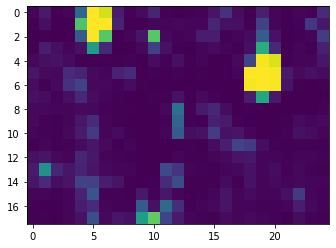

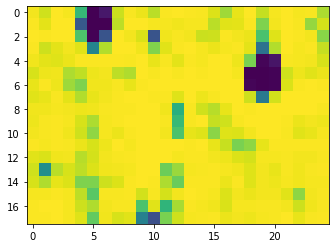

In [24]:
plt.imshow(conf[0, 1].T)
plt.show()
plt.imshow(conf[0, 0].T)
# plt.show()
# plt.imshow(classification[0, 1].T)
# plt.show()
# plt.imshow(classification[0, 0].T)

### 图片金字塔

In [25]:
def pyrdown(image, min_face=12, max_face=0, factor=0.709):
    image_height, image_width = image.shape[:2]
    short_length   = min(image_height, image_width)
    scale          = 1.0  # 原始比率
    scales         = []   # 保存符合条件的缩放
    end_scale      = 12.0 / max_face if max_face != 0 else 0
    begin_scale    = 12.0 / min_face
    
    # 第一次缩小，按最小人脸比例（即最大的scale)
    scale *= begin_scale
    short_length *= scale
    
    # 以后每次按factor比例缩小
    while short_length >= 12.0 and scale >= end_scale:
        img = cv.resize(image, None, fx=scale, fy=scale)
        scales.append([img, scale])
        scale        *= factor
        short_length *= factor
    
    return scales

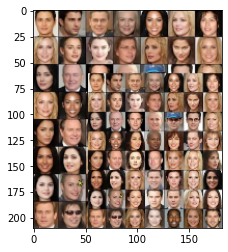

In [26]:
image = cv.imread('faces.png')
pry_images = pyrdown(image[..., ::-1], 50, 90)
show = pry_images[0][0]  # (image, scale_rate)
height, width = show.shape[:2]
for i in range(1, len(pry_images)):
    img = pry_images[i][0]
    left, top = width - img.shape[1], height - img.shape[0]
    show[top:, left:] = img
plt.imshow(show)

1. 遍历金字塔，每一张图片送到P-Net里面处理
2. 每张图片经过滑窗后生成 $m\times n$ 个像素点，过滤出confidence大于阈值的像素点
3. 每个像素点对应 $12\times12$ 的滑窗，反除以缩放倍数，能映射回原图位置（`感受野`）
    - 此时可以画框，但只是表明该区域检测到人脸
4. 从兴趣点的bbox的head里面把四个点找出来，开始映射回原图：
    * step1: 四个点（其实是边距）用的是百分比，在12x12的框里把具体位置算出来
    * step2: 左上角(0, 0)为原点，不变；右下角(cell_size, cell_size)为原点
        + 考虑到压边（即0到1为两个像素），右下角实为(size-1, size-1)
    * step3: 像素点本身坐标分别代表横向和纵向滑动了几次，乘以stride，就可以得到相对原图原点的偏移
    * step4: 非极大值抑制，排除掉重合度非常高的框
    * step4: 原图坐标拿到了就可以draw rectangle了

BBox { 226.30715262136314, 442.82515107842534, 294.8854918517266, 532.7821215639107, conf:0.9999999999778164}

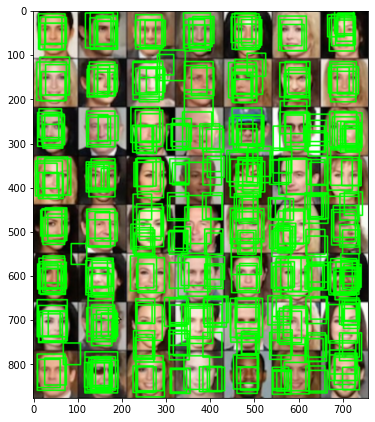

In [30]:
conf_threshold = 0.65
cell_size      = 12
o              = cell_size - 1 # 右下角原点
stride         = 2
faces          = []
for image, scale in pry_images:
    # 归一化， 行优先变列优先等
    image = ((image - 127.5) / 128).transpose(2, 1, 0)[None].astype(np.float32)
    classifi, bbox = pnet(image)
    
    info = '''
        每拿到一张缩放过的图片，就开始往原图推算位置，画框
        比如一张150x150的图片，经过12x12的窗，里面有一个2x2的Maxpooling
        那么会得到70x70个结果，即横向滑动了70次，竖向滑动了70次 <= (150-12)/2 + 1
        (b, c, y, x)
        b: 目前基本是1张图片
        c: 在分类的头里代表"有"和"无", 所以是两层，在bbox的头里代表了四个边距，用四个层表示
        x, y分别表示第几行第几列
    '''
    
    # 1. 拿到人脸概率高的像素的索引
    rows, cols = np.where(classifi[0,1] > conf_threshold)
    for y, x in zip(rows, cols):
        # 2. 拿到confidence
        confidence = classifi[0, 1, y, x]
        # 3. 拿到left, top, right, bottom (边距，比率)
        left   = bbox[0, 0, y, x]
        top    = bbox[0, 1, y, x]
        right  = bbox[0, 2, y, x]
        bottom = bbox[0, 3, y, x]
        # 4. 映射回12 x 12的框内 （长度） (乘以边长，加上原点)
        left   = bbox[0, 0, y, x] * cell_size + 0
        top    = bbox[0, 1, y, x] * cell_size + 0
        right  = bbox[0, 2, y, x] * cell_size + o
        bottom = bbox[0, 3, y, x] * cell_size + o
        # 5. 计算对原图的偏移（x, y为滑动次数，stride为步长）
        left   = bbox[0, 0, y, x] * cell_size + 0 + y * stride
        top    = bbox[0, 1, y, x] * cell_size + 0 + x * stride
        right  = bbox[0, 2, y, x] * cell_size + o + y * stride
        bottom = bbox[0, 3, y, x] * cell_size + o + x * stride
        # 6. 将本图片反缩为原图  
        left   = (bbox[0, 0, y, x] * cell_size + 0 + y * stride) / scale
        top    = (bbox[0, 1, y, x] * cell_size + 0 + x * stride) / scale
        right  = (bbox[0, 2, y, x] * cell_size + o + y * stride) / scale
        bottom = (bbox[0, 3, y, x] * cell_size + o + x * stride) / scale
        i = '''注意这个项目的是用matlab训练的，行列互换了，所以加y和x是反的'''
        # 7. 返回bbox和confidence
        faces.append(BBox(left, top, right, bottom, confidence))
        # 8. 非极大值抑制
faces = nms(faces, 0.65)

show = cv.imread('faces.png')
for f in faces:
    cv.rectangle(show, f.left_top, f.right_bottom, (0, 255, 0), 2, 16)

plt.subplots_adjust(bottom=.1, top=2)
plt.imshow(show[...,::-1])
faces[0]

In [13]:
class RNet(Net):
    def __init__(self, weight_file):
        super().__init__(24)
        self.backbone = Sequencial(
            Conv2d(3, 28, 3), PReLU(28), MaxPooling2d(3, 2),
            Conv2d(28, 48, 3), PReLU(48), MaxPooling2d(3, 2),
            Conv2d(48, 64, 2), PReLU(64),
            Flatten(),
            Linear(576, 128), PReLU(128)
        )
        self.head_confidence = Linear(128, 2)
        self.head_bbox = Linear(128, 4)
        self.load_weight(weight_file,
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "flatten", "conv4", "prelu4"], self.backbone.items)),
            *list(zip(["conv5-1", "conv5-2"], [self.head_confidence, self.head_bbox]))
            )

    def forward(self, x):
        x     = self.backbone(x)
        confi = Softmax()(self.head_confidence(x))
        bbox  = self.head_bbox(x)
        return confi, bbox

class ONet(Net):
    def __init__(self, weight_file):
        super().__init__(48)
        self.backbone = Sequencial(
            Conv2d(3, 32, 3),
            PReLU(32),
            MaxPooling2d(3, 2),
            Conv2d(32, 64, 3),
            PReLU(64),
            MaxPooling2d(3, 2),
            Conv2d(64, 64, 3),
            PReLU(64),
            MaxPooling2d(2, 2),
            Conv2d(64, 128, 2),
            PReLU(128),
            Flatten(),
            Linear(1152, 256),
            PReLU(256)
        )

        self.head_confidence = Linear(256, 2)
        self.head_bbox = Linear(256, 4)
        self.head_landmark = Linear(256, 10)
        self.softmax = Softmax()

        self.load(weight_file, 
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "pool3", "conv4", "prelu4", "flatten", "conv5", "prelu5"], self.backbone.items)),
            *list(zip(["conv6-1", "conv6-2", "conv6-3"], [self.head_confidence, self.head_bbox, self.head_landmark]))
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x), self.head_landmark(x)

1. 拿到pnet出来后的有高人脸概率的坐标组（即上图中的每个绿框）-> ROI
2. 在原图里找到这个坐标把图抠出来
3. 因为是在原图里抠，所以短边之外的部分也包在了24x24的范围内，如果要只保留ROI的内容，可考虑手动切片：
4. 手动切片，就是在原图里把人脸切片出来(而不是24x24)
5. 再生成一张24x24的全黑图片，把切片的人脸居中放上去

Automatic pdb calling has been turned ON


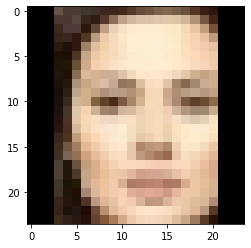

In [14]:
%pdb
def crop_resize(src, roi, dst):
    '''
    @src: ndarray, 原图
    @roi: tuple, (left, top, right, bottom), 抠图坐标
    @dst: int, 返回图片大小（方形）
    '''
    l, t, r, b = [int(m) for m in roi]
    width   = r - l + 1
    height  = b - t + 1
    scale   = dst / max(width, height)
    m_bg    = np.zeros((dst, dst, 3)).astype(np.uint8)
    m_roi   = src[t:b, l:r]
    m_roi   = cv.resize(m_roi, None, fx=scale, fy=scale)
    height, width = m_roi.shape[:2]  # 变形后的大小(总有一个是24) 
    # 开始判断长短边，正确“居中”摆到黑底上去
    if width == 24:
        # 垂直居中
        offset = (dst - height) // 2
        m_bg[offset:offset+height, :] = m_roi
    else:
        # 水平居中
        offset = (dst - width) // 2
        m_bg[:, offset:offset+width] = m_roi
    return m_bg

box = BBox(226.30715262136314, 442.82515107842534, 294.8854918517266, 532.7821215639107, confidence=0.9999999999778164)
img = cv.imread('faces.png')
img = crop_resize(img, box.locations(), 24)
plt.imshow(img[...,::-1])

In [6]:
class RNet(Net):
    def __init__(self, weight_file):
        super().__init__(24)
        self.backbone = Sequencial(
            Conv2d(3, 28, 3),
            PReLU(28),
            MaxPooling2d(3, 2),
            Conv2d(28, 48, 3),
            PReLU(48),
            MaxPooling2d(3, 2),
            Conv2d(48, 64, 2),
            PReLU(64),
            Flatten(),
            Linear(576, 128),
            PReLU(128)
        )
        
        self.head_confidence = Linear(128, 2)
        self.head_bbox = Linear(128, 4)
        self.softmax = Softmax()
        
        self.load_weight(weight_file, 
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "flatten", "conv4", "prelu4"], self.backbone.items)),
            *list(zip(["conv5-1", "conv5-2"], [self.head_confidence, self.head_bbox]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)

class ONet(Net):
    def __init__(self, weight_file):
        super().__init__(48)
        self.backbone = Sequencial(
            Conv2d(3, 32, 3),
            PReLU(32),
            MaxPooling2d(3, 2),
            Conv2d(32, 64, 3),
            PReLU(64),
            MaxPooling2d(3, 2),
            Conv2d(64, 64, 3),
            PReLU(64),
            MaxPooling2d(2, 2),
            Conv2d(64, 128, 2),
            PReLU(128),
            Flatten(),
            Linear(1152, 256),
            PReLU(256)
        )
        
        self.head_confidence = Linear(256, 2)
        self.head_bbox = Linear(256, 4)
        self.head_landmark = Linear(256, 10)
        self.softmax = Softmax()
        
        self.load_weight(weight_file, 
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "pool3", "conv4", "prelu4", "flatten", "conv5", "prelu5"], self.backbone.items)),
            *list(zip(["conv6-1", "conv6-2", "conv6-3"], [self.head_confidence, self.head_bbox, self.head_landmark]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x), self.head_landmark(x)



CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
totle time: 1.79328s


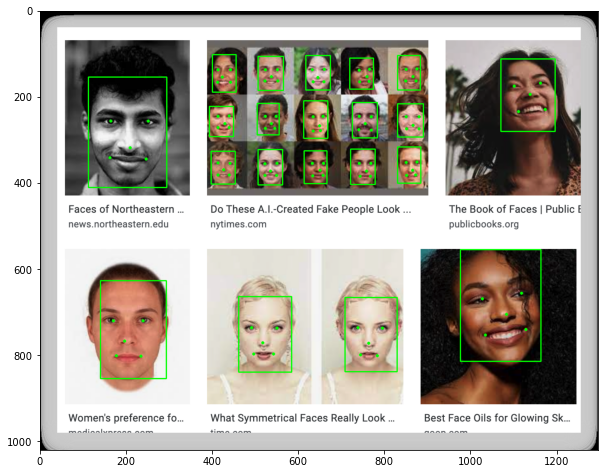

In [8]:
%time
class MTCNN(Module):
    def __init__(self):
        self.pnet = PNet("mtcnn/det1.caffemodel")
        self.rnet = RNet("mtcnn/det2.caffemodel")
        self.onet = ONet("mtcnn/det3.caffemodel")


    def pyrdown(self, image, min_face=12, max_face=0, factor=0.709):
        image_height, image_width = image.shape[:2]
        short_length   = min(image_height, image_width)
        scale          = 1.0  # 原始比率
        scales         = []   # 保存符合条件的缩放
        end_scale      = 12.0 / max_face if max_face != 0 else 0
        begin_scale    = 12.0 / min_face

        # 第一次缩小，按最小人脸比例（即最大的scale)
        scale *= begin_scale
        short_length *= scale

        # 以后每次按factor比例缩小
        while short_length >= 12.0 and scale >= end_scale:
            img = cv.resize(image, None, fx=scale, fy=scale)
            scales.append([img, scale])
            scale        *= factor
            short_length *= factor
        
        return scales
    

    def proposal(self, net, imagepairs, conf_threshold=0.6, nms_threshold=0.5):
        '''
        Net 模型
        @imagepairs: [[图像，scale], [图像，scale]]
        @confidence_threshold: 正类概率的阈值
        @nms_threshold: 非极大值抑制的阈值
        '''
        cell_size      = net.size
        o              = cell_size - 1 # 右下角原点
        stride         = 2
        faces          = []
        for image, scale in imagepairs:
            # 行优先变列优先 (matlab训练的数据)
            image = image.transpose(2, 1, 0)[None].astype(np.float32)
            classifi, bbox = net(image)
            # 1. 拿到人脸概率高的像素的索引
            rows, cols = np.where(classifi[0,1] > conf_threshold)
            for y, x in zip(rows, cols):
                # 2. 拿到confidence
                confidence = classifi[0, 1, y, x]
                # 3. 拿到left, top, right, bottom (边距，比率)
                # 4. 映射回12 x 12的框内 （长度） (乘以边长，加上原点)
                # 5. 计算对原图的偏移（x, y为滑动次数，stride为步长）
                # 6. 将本图片反缩为原图  
                left   = (bbox[0, 0, y, x] * cell_size + 0 + y * stride) / scale
                top    = (bbox[0, 1, y, x] * cell_size + 0 + x * stride) / scale
                right  = (bbox[0, 2, y, x] * cell_size + o + y * stride) / scale
                bottom = (bbox[0, 3, y, x] * cell_size + o + x * stride) / scale
                i = '''注意这个项目的是用matlab训练的，行列互换了，所以加y和x是反的'''
                # 7. 返回bbox和confidence
                faces.append(BBox(left, top, right, bottom, confidence))
                # 8. 非极大值抑制
        faces = nms(faces, nms_threshold)
        
        return faces
    
    def crop_resize(self, src, roi, dst):
        '''
        @src: ndarray, 原图
        @roi: tuple, (left, top, right, bottom), 抠图坐标
        @dst: int, 返回图片大小（方形）
        '''
        l, t, r, b = [int(m) if m>0 else 0 for m in roi]
        width   = r - l + 1
        height  = b - t + 1
        scale   = dst / max(width, height)
        m_bg    = np.zeros((dst, dst, 3)).astype(np.float32)
        m_roi   = src[t:b, l:r]
        m_roi   = cv.resize(m_roi, None, fx=scale, fy=scale)
        height, width = m_roi.shape[:2]  # 变形后的大小(总有一个是24) 
        # 开始判断长短边，正确“居中”摆到黑底上去
        offset = (dst - min(height, width)) // 2
        if width > height:
            # 垂直居中
            m_bg[offset:offset+height, :width] = m_roi
        else:
            # 水平居中
            m_bg[:height, offset:offset+width] = m_roi
        return m_bg


    def refine(self, net, objs, image, has_landmark, conf_threshold=0.7, nms_threshold=0.7):
        '''
        R-Net和O-Net通用，对上一轮推理的图片进行微调，即用新的卷积+全连接进行推理，进行更精确的检测
        A：
        将图像居中缩放到24大小，丢入rnet
        或
        将图像居中缩放到48大小，丢入onet
        B：
        拿到的confidence，reg_bbox, points(of onet)->landmark分别映射回原图坐标，
        C：
        把landmark与bounding关联上，再对bbox进行非极大值抑制，输出
        
        @objs: bbox 四个角的坐标已经还原回了原图
        '''
        if not objs:
            return
        croped_images = []
        for obj in objs:
            crop = self.crop_resize(image, obj.locations(), net.size)
            croped_images.append(crop.transpose(2, 1, 0)[None])  # HWC -> CWH

        images = np.vstack(croped_images)  # ->BCWH
        predict = net(images)
        conf_all, reg_all = predict[:2]
        if has_landmark:
            landmark = predict[2]
        
        # 此时，每一个obj又进行了一次推理，得到一组新的(confidence和bounding)，
        # 而且每张图片只会有一组bounding和confidence了
        # bounding是相对24x24的框的边距，由于是正方形，如果我们把原图从中心根据长边也扩展成正方形坐标
        # 那么新的bounding也可以理解为原图尺度下的了
        # p-net只有一张图片，所以bchw里的b永远是1，现在开始就有N张了，返回的数组也跟b相关
        keep_objs = []
        for index, obj in enumerate(objs):
            # 与p-net不同，r/o-net里一个框里最多只有一张脸了，所以返回值是四维（图片/特征/行/列）
            # 因为只返回一个元素，所以行列没意义了，成了N张图片，每张图片存了两个置信度，四个边距的结构
            # 不需要知道每张图片对应在原图的位置，现在这样更直观：
            # conf: [[0.1, 0.9], [0.2, 0.8], ...]
            # bbox: [[a,b,c,d], [a,b,c,d], ...]
            
            conf, reg = conf_all[index, 1], reg_all[index]
            if conf < conf_threshold:
                continue
            rl, rt, rr, rb = reg
            # 用图片中心加/减长边的一半，就可以得到中心不变，短边补长后的坐标 (center - max/2)
            # 然后再根据边距算出新的四个角 (center - max/2 + margin)
            # TODO: 注意rl, rt, rr, rb是行列互换过后的，但示例代码直接用于原图，先不改看看
            # 原因是，最外层的数据表示才有转置不转置一说，对各自实现的内部，永远人头永远是正的，上下左右也都是正的
            # 所以拿到的四个边距就是人脸距离边框的距离，只是显示图片和送入数据的时候，需要考虑转置而已
            maxl   = max(obj.width, obj.height)
            left   = obj.center_x - maxl * 0.5 + maxl * rl
            top    = obj.center_y - maxl * 0.5 + maxl * rt
            right  = obj.center_x + maxl * 0.5 + maxl * rr
            bottom = obj.center_y + maxl * 0.5 + maxl * rb
            bbox   = BBox(left, top, right, bottom, conf)  # 新的bbox，坐标仍是原图的

            if has_landmark:
                points = landmark[index]
                bbox.landmarks = []   # [[y,x],...x5...]
                for x, y in zip(points[:5], points[5:]):
                    # 兴趣点也是相对传入的24x24的正方形的，我们仍然只需要把原图按中心和长边扩成正方形
                    # 兴趣点是相对左上角的偏移，按上面计算left/top的方式可得到新的坐标
                    x = obj.center_x - maxl * 0.5 + maxl * x
                    y = obj.center_y - maxl * 0.5 + maxl * y
                    bbox.landmarks.append((x, y)) # 主要用于绘图，我们存成x,y的顺序，记住

            keep_objs.append(bbox)

        return nms(keep_objs, nms_threshold)
        
    # 目标检测，要求输入的是bgr的图像，3通道
    def detect(self, image, min_size=30, max_face=0):
        # 因为这个模型是matlab训练的，图像加载采用的是RGB格式
        self.input_image = image[..., ::-1] # BGR2RGB
        # 对图像进行归一化
        self.input_image = ((self.input_image - 127.5) / 128.0).astype(np.float32)
        # 图像金字塔，产生多尺度的图像，用以PNet进行检测
        self.pyrs = self.pyrdown(self.input_image, min_size, max_face)
        # 推荐框，proposal，recall要比较高的场景，错误会很高，但是召回率高就行
        self.objs = self.proposal(self.pnet, self.pyrs, nms_threshold=0.6)
        self.robjs = self.refine(self.rnet, self.objs, self.input_image, False, nms_threshold=0.6)
        self.oobjs = self.refine(self.onet, self.robjs, self.input_image, True, nms_threshold=0.5)
        return self.oobjs

if __name__ == "__main__":
    import time
    image = cv.imread("faces2.png")
    start = time.time()
    # cv.rectangle(image, (30, 50), (146, 213), (0, 0, 200), 2, 8)
    (h, w, _), s = image.shape, .3
    img = cv.resize(image, (round(w*s), round(h*s)))
    mtcnn = MTCNN()
    objs = mtcnn.detect(img, 30, min(h, w) * 0.8)  # 设定人脸最大阈值占短边80%
    print(f'totle time: {time.time()-start:.5f}s')
    for obj in mtcnn.oobjs:
        bx, by, br, bb = [round(m/s) for m in obj.locations()]
        cv.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
        
        for x, y in obj.landmarks:
            cv.circle(image, (int(x/s), int(y/s)), 3, (0, 255, 0), -1, 16)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(image[...,::-1])
    plt.show()